## 0. Initialize

#### 0.1. Arrhythmia data load & resampling

In [15]:
import numpy as np
from keras import layers, models
from keras import Input
from keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from os import walk
import glob
from scipy import signal
import tensorflow as tf
from sklearn.model_selection import train_test_split

import wfdb

# arrhythmia data load
arrhythmia = 'mitdb/'
condition = '*.dat'
arrhy_sampto = 3600

arrhy_data = []
arrhy_lb = []
arrhy_data_set = []

for f in walk(arrhythmia):
    arrhy_data = glob.glob(condition)
    
for filename in glob.glob('mitdb/*.hea'):
    arrhy_data.append(filename[0:-4])
 
for i in range(len(arrhy_data)):
    signals, fields = wfdb.rdsamp(arrhy_data[i], sampto = arrhy_sampto * 180)   #num = 650000
    arrhy_data[i] = signals[:, 0]

arrhy_data = np.array(arrhy_data, dtype = np.float16)

for i in range(len(arrhy_data)):
    for j in range(180):
        arrhy_data_set.append(arrhy_data[i, j * arrhy_sampto : arrhy_sampto * (j + 1)])
        arrhy_lb.append([1., 0.])    
     
arrhy_lb = np.array(arrhy_lb)        
arrhy_data_set = np.array(arrhy_data_set, dtype = np.float16)

# UpSampling
sampled_arrhy = signal.upfirdn([np.float16(1.)], arrhy_data_set, 64)
print(sampled_arrhy.shape)
                       
# LPF
lowpass = signal.firwin(128, cutoff = 1/180, fs = 360, pass_zero = 'lowpass')  
sampled_arrhy = signal.lfilter(lowpass, [np.float16(1.)], sampled_arrhy)
print(sampled_arrhy.shape)

# DownSapmling
sampled_arrhy = signal.upfirdn([np.float16(1.)], sampled_arrhy, 1, 180)
print(sampled_arrhy.shape)                    

(8640, 230337)
(8640, 230337)
(8640, 1280)


#### 0.2. Normal data load

In [16]:
# normal data load
normal = 'mit-bih-normal-sinus-rhythm-database-1.0.0/'
condition = '*.dat'
normal_sampto = 1280

normal_data = []
normal_lb = []
normal_data_set = []

for f in walk(normal):
    normal_data = glob.glob(condition)
    
for filename in glob.glob('mit-bih-normal-sinus-rhythm-database-1.0.0/*.hea'):
    normal_data.append(filename[0:-4])
 
for i in range(len(normal_data)):
    signals, fields = wfdb.rdsamp(normal_data[i], sampto = normal_sampto * 1500)   #num = 11520000
    normal_data[i] = signals[:, 0]
    
normal_data = np.array(normal_data)    

for i in range(len(normal_data)):
    for j in range(1500):
        normal_data_set.append(normal_data[i, j * normal_sampto : normal_sampto * (j + 1)])
        normal_lb.append([0., 1.])    
     
normal_lb = np.array(normal_lb)        
normal_data_set = np.array(normal_data_set, dtype = np.float16)

print(normal_data_set.shape, normal_lb.shape)

(27000, 1280) (27000, 2)


#### 0.3. Data normalization

In [17]:
# normalization arrhythmia data
for i in range(len(sampled_arrhy)):
    sampled_arrhy[i] = (sampled_arrhy[i] - sampled_arrhy[i].min()) /(sampled_arrhy[i].max() - sampled_arrhy[i].min())
  
# normalization normal data
for i in range(len(normal_data_set)):
    normal_data_set[i] = (normal_data_set[i] - normal_data_set[i].min()) /(normal_data_set[i].max() - normal_data_set[i].min())

# setting training data set
training_data_set = np.append(sampled_arrhy, normal_data_set, axis = 0)

# setting training data label
training_lb = np.append(arrhy_lb, normal_lb, axis = 0)

print(training_data_set.shape, training_lb.shape, type(training_data_set))

(35640, 1280) (35640, 2) <class 'numpy.ndarray'>


#### 0.4. Data seperation

In [18]:
x_train, x_test, y_train, y_test = train_test_split(training_data_set, training_lb)

print('x_test: ', x_test.shape)
print('y_tset: ', y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val: ', x_val.shape)
print('y_val: ', y_val.shape)

x_test:  (8910, 1280)
y_tset:  (8910, 2)
x_train:  (20047, 1280)
y_train:  (20047, 2)
x_val:  (6683, 1280)
y_val:  (6683, 2)


## 1. VGG16 Net

### 1.0. VGG-16 Net(No DropOut)

Epoch 1/50
627/627 [==============================] - 36s 35ms/step - loss: 0.2413 - accuracy: 0.9073 - val_loss: 0.1085 - val_accuracy: 0.9666
Epoch 2/50
627/627 [==============================] - 21s 34ms/step - loss: 0.0853 - accuracy: 0.9716 - val_loss: 0.0795 - val_accuracy: 0.9741
Epoch 3/50
627/627 [==============================] - 21s 34ms/step - loss: 0.0467 - accuracy: 0.9840 - val_loss: 0.0638 - val_accuracy: 0.9799
Epoch 4/50
627/627 [==============================] - 21s 34ms/step - loss: 0.0354 - accuracy: 0.9879 - val_loss: 0.0410 - val_accuracy: 0.9861
Epoch 5/50
627/627 [==============================] - 21s 34ms/step - loss: 0.0223 - accuracy: 0.9922 - val_loss: 0.0622 - val_accuracy: 0.9810
Epoch 6/50
627/627 [==============================] - 21s 33ms/step - loss: 0.0173 - accuracy: 0.9934 - val_loss: 0.0817 - val_accuracy: 0.9716
Epoch 7/50
627/627 [==============================] - 21s 33ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.0264 - val_accuracy:

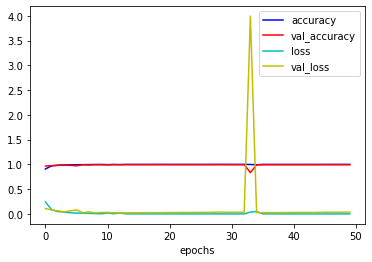

In [5]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
l2 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l1)

#Conv2
p1 = layers.MaxPooling1D(2, strides = 2)(l2)
l3 = layers.Conv1D(channels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p1)
l4 = layers.Conv1D(channels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(l3)

#Conv3
p2 = layers.MaxPooling1D(2, strides = 2)(l4)
l5 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p2)
l6 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l5)
l7 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)

#Conv4
p3 = layers.MaxPooling1D(2, strides = 2)(l7)
l8 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p3)
l9 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l9)

#Conv5
p4 = layers.MaxPooling1D(2, strides = 2)(l10)
l11 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
l12 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l11)
l13 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
x = layers.Flatten()(l13)

#FC1
fc1 = layers.Dense(4096, kernel_initializer='he_normal')(x)

#FC2
fc2 = layers.Dense(2048, kernel_initializer='he_normal')(fc1)

#FC3
fc3 = layers.Dense(1024, kernel_initializer='he_normal')(fc2)

#Output Layer
output_tensor = layers.Dense(2, activation='softmax')(fc3)

vgg16_ecg = Model(input_tensor, output_tensor)

vgg16_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = vgg16_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_val, y_val))

test_loss, test_acc = vgg16_ecg.evaluate(x_test, y_test)

print(vgg16_ecg.summary)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 1.0.1. Check VGG16

In [6]:
y_predict = vgg16_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))        

8844.0
prediction arrhythmia as normal:  51
prediction normal as arrhythmia:  15


In [29]:
num_of_positive = []

for i in range(len(y_test)):
    if (y_test[i] == [1., 0.]).all() == True:
            num_of_positive.append(i)
print(len(num_of_positive))

num_of_negative = []

for i in range(len(y_test)):
    if (y_test[i] == [0., 1.]).all() == True:
            num_of_negative.append(i)
print(len(num_of_negative))

2231
6679


### 1.1. VGG-16 Net(DropOut Between Conv and Maxpooling)

Epoch 1/50
627/627 [==============================] - 43s 66ms/step - loss: 0.8699 - accuracy: 0.7161 - val_loss: 0.6821 - val_accuracy: 0.5435
Epoch 2/50
627/627 [==============================] - 21s 34ms/step - loss: 0.5423 - accuracy: 0.7575 - val_loss: 0.6459 - val_accuracy: 0.6226
Epoch 3/50
627/627 [==============================] - 21s 34ms/step - loss: 0.4506 - accuracy: 0.8002 - val_loss: 0.4177 - val_accuracy: 0.8775
Epoch 4/50
627/627 [==============================] - 21s 34ms/step - loss: 0.3126 - accuracy: 0.8797 - val_loss: 0.2547 - val_accuracy: 0.9246
Epoch 5/50
627/627 [==============================] - 21s 33ms/step - loss: 0.2558 - accuracy: 0.9082 - val_loss: 0.2191 - val_accuracy: 0.9231
Epoch 6/50
627/627 [==============================] - 21s 34ms/step - loss: 0.2395 - accuracy: 0.9133 - val_loss: 0.2171 - val_accuracy: 0.9307
Epoch 7/50
627/627 [==============================] - 21s 34ms/step - loss: 0.2224 - accuracy: 0.9201 - val_loss: 0.2186 - val_accuracy:

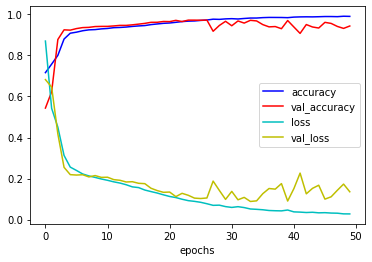

In [7]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
l2 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l1)

#Conv2
p1 = layers.MaxPooling1D(2, strides = 2)(l2)
l3 = layers.Conv1D(channels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p1)
l4 = layers.Conv1D(channels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(l3)
d2 = layers.Dropout(rate = 0.5)(l4)

#Conv3
p2 = layers.MaxPooling1D(2, strides = 2)(d2)
l5 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p2)
l6 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l5)
l7 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
d5 = layers.Dropout(rate = 0.5)(l7)

#Conv4
p3 = layers.MaxPooling1D(2, strides = 2)(d5)
l8 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p3)
l9 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l9)
d8 = layers.Dropout(rate = 0.5)(l10)

#Conv5
p4 = layers.MaxPooling1D(2, strides = 2)(d8)
l11 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
l12 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l11)
l13 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
d11 = layers.Dropout(rate = 0.5)(l13)
x = layers.Flatten()(d11)

#FC1
fc1 = layers.Dense(4096, kernel_initializer='he_normal')(x)

#FC2
fc2 = layers.Dense(2048, kernel_initializer='he_normal')(fc1)

#FC3
fc3 = layers.Dense(1024, kernel_initializer='he_normal')(fc2)

#Output Layer
output_tensor = layers.Dense(2, activation='softmax')(fc3)

vgg16_ecg = Model(input_tensor, output_tensor)

vgg16_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = vgg16_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_val, y_val))

test_loss, test_acc = vgg16_ecg.evaluate(x_test, y_test)

vgg16_ecg.summary()

print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 1.1.1. VGG-16 Net(DropOut Between Conv and Maxpooling) Check

In [8]:
y_predict = vgg16_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))    

8450.0
prediction arrhythmia as normal:  19
prediction normal as arrhythmia:  441


### 1.2. VGG-16 Net(with Batch Normalization)

Epoch 1/50
627/627 [==============================] - 27s 39ms/step - loss: 0.2779 - accuracy: 0.9168 - val_loss: 0.1199 - val_accuracy: 0.9618
Epoch 2/50
627/627 [==============================] - 24s 38ms/step - loss: 0.0767 - accuracy: 0.9771 - val_loss: 0.0572 - val_accuracy: 0.9823
Epoch 3/50
627/627 [==============================] - 23s 37ms/step - loss: 0.0431 - accuracy: 0.9864 - val_loss: 0.0525 - val_accuracy: 0.9882
Epoch 4/50
627/627 [==============================] - 24s 38ms/step - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.0498 - val_accuracy: 0.9876
Epoch 5/50
627/627 [==============================] - 24s 38ms/step - loss: 0.0337 - accuracy: 0.9904 - val_loss: 0.0442 - val_accuracy: 0.9862
Epoch 6/50
627/627 [==============================] - 23s 37ms/step - loss: 0.0132 - accuracy: 0.9952 - val_loss: 0.0339 - val_accuracy: 0.9915
Epoch 7/50
627/627 [==============================] - 23s 37ms/step - loss: 0.0260 - accuracy: 0.9925 - val_loss: 0.0264 - val_accuracy:

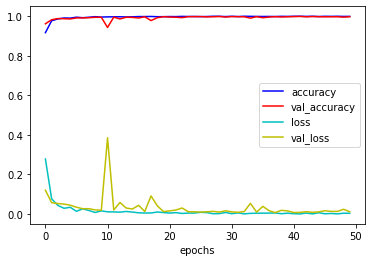

In [9]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
l2 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l1)

#Conv2
p1 = layers.MaxPooling1D(2, strides = 2)(l2)
l3 = layers.Conv1D(channels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p1)
l4 = layers.Conv1D(channels*2, 3, padding='same', kernel_initializer='he_normal')(l3)
d2 = layers.BatchNormalization()(l4)
d2 = layers.Activation('relu')(d2)

#Conv3
p2 = layers.MaxPooling1D(2, strides = 2)(d2)
l5 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p2)
l6 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l5)
l7 = layers.Conv1D(channels*4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l6)
d5 = layers.BatchNormalization()(l7)
d5 = layers.Activation('relu')(d5)

#Conv4
p3 = layers.MaxPooling1D(2, strides = 2)(d5)
l8 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p3)
l9 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels*8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
d8 = layers.BatchNormalization()(l10)
d8 = layers.Activation('relu')(d8)

#Conv5
p4 = layers.MaxPooling1D(2, strides = 2)(d8)
l11 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
l12 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l11)
l13 = layers.Conv1D(channels*8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l12)
d11 = layers.BatchNormalization()(l13)
d11 = layers.Activation('relu')(d11)
x = layers.Flatten()(d11)

#FC1
fc1 = layers.Dense(4096, kernel_initializer='he_normal')(x)

#FC2
fc2 = layers.Dense(2048, kernel_initializer='he_normal')(fc1)

#FC3
fc3 = layers.Dense(1024, kernel_initializer='he_normal')(fc2)

#Output Layer
output_tensor = layers.Dense(2, activation='softmax')(fc3)

vgg16_ecg = Model(input_tensor, output_tensor)

vgg16_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = vgg16_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_val, y_val))

test_loss, test_acc = vgg16_ecg.evaluate(x_test, y_test)

vgg16_ecg.summary()

print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 1.2.1. VGG-16 Net(with Batch Normalization)

In [10]:
y_predict = vgg16_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))    

8879.0
prediction arrhythmia as normal:  8
prediction normal as arrhythmia:  23


### 1.1.3. VGG-16 Net(with Reguraliztaion)

(None, 80, 256)
(None, 20480)
Epoch 1/50
627/627 [==============================] - 23s 35ms/step - loss: 1.6849 - accuracy: 0.9028 - val_loss: 1.5059 - val_accuracy: 0.9536
Epoch 2/50
627/627 [==============================] - 22s 35ms/step - loss: 1.4319 - accuracy: 0.9675 - val_loss: 1.3784 - val_accuracy: 0.9738
Epoch 3/50
627/627 [==============================] - 21s 34ms/step - loss: 1.3269 - accuracy: 0.9810 - val_loss: 1.4191 - val_accuracy: 0.9333
Epoch 4/50
627/627 [==============================] - 21s 33ms/step - loss: 1.2539 - accuracy: 0.9868 - val_loss: 1.2227 - val_accuracy: 0.9888
Epoch 5/50
627/627 [==============================] - 21s 34ms/step - loss: 1.1860 - accuracy: 0.9917 - val_loss: 1.1616 - val_accuracy: 0.9915
Epoch 6/50
627/627 [==============================] - 21s 34ms/step - loss: 1.1425 - accuracy: 0.9911 - val_loss: 1.1226 - val_accuracy: 0.9897
Epoch 7/50
627/627 [==============================] - 20s 32ms/step - loss: 1.0901 - accuracy: 0.9941 - va

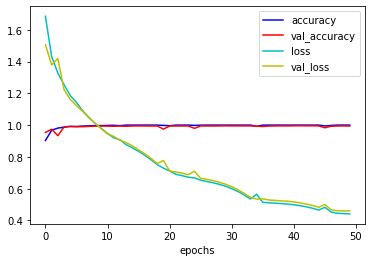

In [15]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
l2 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l1)

#Conv2
p1 = layers.MaxPooling1D(2, strides = 2)(l2)
l3 = layers.Conv1D(channels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p1)
l4 = layers.Conv1D(channels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l3)


#Conv3
p2 = layers.MaxPooling1D(2, strides = 2)(l4)
l5 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p2)
l6 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l5)
l7 = layers.Conv1D(channels*4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l6)


#Conv4
p3 = layers.MaxPooling1D(2, strides = 2)(l7)
l8 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p3)
l9 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l9)


#Conv5
p4 = layers.MaxPooling1D(2, strides = 2)(l10)
l11 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
l12 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l11)
l13 = layers.Conv1D(channels*8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l12)
print(l13.shape)
x = layers.Flatten()(l13)

print(x.shape)
#FC1
fc1 = layers.Dense(4096, kernel_initializer='he_normal')(x)

#FC2
fc2 = layers.Dense(2048, kernel_initializer='he_normal')(fc1)

#FC3
fc3 = layers.Dense(1024, kernel_initializer='he_normal')(fc2)

#Output Layer
output_tensor = layers.Dense(2, activation='softmax')(fc3)

vgg16_ecg = Model(input_tensor, output_tensor)

vgg16_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = vgg16_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_val, y_val))

val_loss, test_acc = vgg16_ecg.evaluate(x_test, y_test)

vgg16_ecg.summary()

print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 1.3.1. VGG-16 Net(with Reguraliztaion) Check

In [16]:
y_predict = vgg16_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

8855.0
prediction arrhythmia as normal:  43
prediction normal as arrhythmia:  12


## 2. ResNet-18

In [17]:
x_train.shape, y_train.shape

((20047, 1280), (20047, 2))

### 2.0. ResNet-18

Epoch 1/50
627/627 [==============================] - 37s 33ms/step - loss: 0.4521 - accuracy: 0.8593 - val_loss: 0.2271 - val_accuracy: 0.9210
Epoch 2/50
627/627 [==============================] - 20s 32ms/step - loss: 0.1721 - accuracy: 0.9426 - val_loss: 0.1159 - val_accuracy: 0.9642
Epoch 3/50
627/627 [==============================] - 20s 31ms/step - loss: 0.1148 - accuracy: 0.9628 - val_loss: 0.0928 - val_accuracy: 0.9768
Epoch 4/50
627/627 [==============================] - 20s 31ms/step - loss: 0.0850 - accuracy: 0.9742 - val_loss: 0.0730 - val_accuracy: 0.9768
Epoch 5/50
627/627 [==============================] - 20s 31ms/step - loss: 0.0726 - accuracy: 0.9770 - val_loss: 0.0521 - val_accuracy: 0.9843
Epoch 6/50
627/627 [==============================] - 20s 31ms/step - loss: 0.0605 - accuracy: 0.9807 - val_loss: 0.0413 - val_accuracy: 0.9868
Epoch 7/50
627/627 [==============================] - 20s 31ms/step - loss: 0.0439 - accuracy: 0.9865 - val_loss: 0.0360 - val_accuracy:

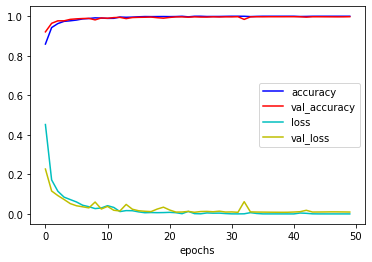

In [6]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l2 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l4 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l6 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l8 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l12 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l14 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l16 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 2.0.1. ResNet-18 Check

In [7]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

8888.0
prediction arrhythmia as normal:  11
prediction normal as arrhythmia:  11


### 2.1. ResNet-18(with DropOut)

Epoch 1/50
627/627 [==============================] - 76s 117ms/step - loss: 25.0285 - accuracy: 0.6669 - val_loss: 2.1049 - val_accuracy: 0.7601
Epoch 2/50
627/627 [==============================] - 72s 114ms/step - loss: 7.0293 - accuracy: 0.6779 - val_loss: 1.1449 - val_accuracy: 0.7601
Epoch 3/50
627/627 [==============================] - 72s 114ms/step - loss: 4.8150 - accuracy: 0.6762 - val_loss: 0.6963 - val_accuracy: 0.7600
Epoch 4/50
627/627 [==============================] - 76s 121ms/step - loss: 3.2195 - accuracy: 0.6816 - val_loss: 1.8648 - val_accuracy: 0.2451
Epoch 5/50
627/627 [==============================] - 73s 116ms/step - loss: 2.4347 - accuracy: 0.6875 - val_loss: 3.7980 - val_accuracy: 0.2399
Epoch 6/50
627/627 [==============================] - 76s 122ms/step - loss: 1.8832 - accuracy: 0.6931 - val_loss: 5.6546 - val_accuracy: 0.2399
Epoch 7/50
627/627 [==============================] - 77s 123ms/step - loss: 1.5837 - accuracy: 0.7023 - val_loss: 5.6417 - val_a

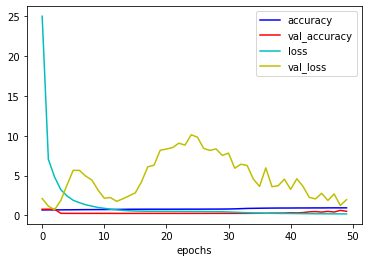

In [20]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l1 = layers.Dropout(rate = 0.5)(l1)
l2 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l3 = layers.Dropout(rate = 0.5)(l3)
l4 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l5 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l5 = layers.Dropout(rate = 0.5)(l5)
l6 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
l4 = layers.BatchNormalization()(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l7 = layers.Dropout(rate = 0.5)(l7)
l8 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l9 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l9 = layers.Dropout(rate = 0.5)(l9)
l10 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
l8 = layers.BatchNormalization()(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l11 = layers.Dropout(rate = 0.5)(l11)
l12 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l13 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l13 = layers.Dropout(rate = 0.5)(l13)
l14 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
l12 = layers.BatchNormalization()(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l14 = layers.Dropout(rate = 0.5)(l14)
l16 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.MaxPooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))
    
print(ResNet18_ecg.summary())    

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 2.1.1. ResNet-18(with DropOut) Check

In [21]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

4539.0
prediction arrhythmia as normal:  207
prediction normal as arrhythmia:  4164


### 2.2. ResNet-18(with BatchNomralization)

Epoch 1/50
627/627 [==============================] - 39s 42ms/step - loss: 0.2964 - accuracy: 0.8971 - val_loss: 0.1971 - val_accuracy: 0.9366
Epoch 2/50
627/627 [==============================] - 26s 41ms/step - loss: 0.0839 - accuracy: 0.9728 - val_loss: 0.0644 - val_accuracy: 0.9816
Epoch 3/50
627/627 [==============================] - 26s 41ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0385 - val_accuracy: 0.9882
Epoch 4/50
627/627 [==============================] - 26s 41ms/step - loss: 0.0320 - accuracy: 0.9898 - val_loss: 0.0274 - val_accuracy: 0.9910
Epoch 5/50
627/627 [==============================] - 26s 41ms/step - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.0221 - val_accuracy: 0.9930
Epoch 6/50
627/627 [==============================] - 26s 41ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0235 - val_accuracy: 0.9921
Epoch 7/50
627/627 [==============================] - 26s 41ms/step - loss: 0.0125 - accuracy: 0.9962 - val_loss: 0.0167 - val_accuracy:

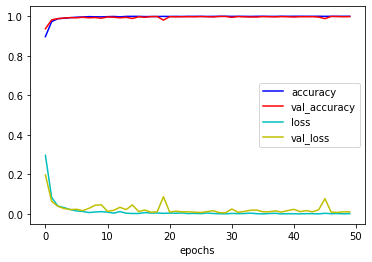

In [5]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l1 = layers.BatchNormalization()(l1)
l2 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l3 = layers.BatchNormalization()(l3)
l4 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l5 = layers.BatchNormalization()(l5)
l6 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l7 = layers.BatchNormalization()(l7)
l8 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l9 = layers.BatchNormalization()(l9)
l10 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l11 = layers.BatchNormalization()(l11)
l12 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l13 = layers.BatchNormalization()(l13)
l14 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l14 = layers.BatchNormalization()(l14)
l16 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))
    
print(ResNet18_ecg.summary())    

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 2.2.1 ResNet-18(with BatchNormalization) Check

In [6]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

8885.0
prediction arrhythmia as normal:  15
prediction normal as arrhythmia:  10


### 2.3. ResNet-18(with Reguralization) Check

Epoch 1/50
627/627 [==============================] - 61s 94ms/step - loss: 2.8057 - accuracy: 0.8490 - val_loss: 2.4589 - val_accuracy: 0.8385
Epoch 2/50
627/627 [==============================] - 58s 93ms/step - loss: 1.9361 - accuracy: 0.9441 - val_loss: 1.9083 - val_accuracy: 0.9415
Epoch 3/50
627/627 [==============================] - 58s 93ms/step - loss: 1.7974 - accuracy: 0.9665 - val_loss: 1.7537 - val_accuracy: 0.9750
Epoch 4/50
627/627 [==============================] - 58s 93ms/step - loss: 1.6939 - accuracy: 0.9823 - val_loss: 1.8896 - val_accuracy: 0.9062
Epoch 5/50
627/627 [==============================] - 58s 93ms/step - loss: 1.6230 - accuracy: 0.9852 - val_loss: 1.6284 - val_accuracy: 0.9759
Epoch 6/50
627/627 [==============================] - 58s 93ms/step - loss: 1.5613 - accuracy: 0.9876 - val_loss: 1.5710 - val_accuracy: 0.9798
Epoch 7/50
627/627 [==============================] - 58s 93ms/step - loss: 1.5049 - accuracy: 0.9908 - val_loss: 1.5281 - val_accuracy:

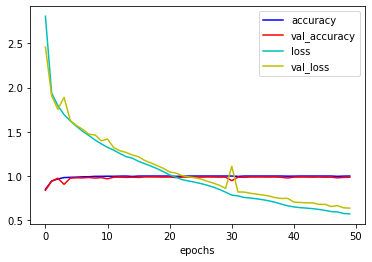

In [7]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l0)
l2 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l2)
l4 = layers.Conv1D(channels, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l5 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l4)
l6 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l6)
l8 = layers.Conv1D(channels * 2, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l9 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l8)
l10 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l10)
l12 = layers.Conv1D(channels * 4, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l13 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l12)
l14 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 3, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(l14)
l16 = layers.Conv1D(channels * 8, 3, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

#### 2.3.1 ResNet-18(with Reguralization) Check

In [8]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   
print('****end****')

8792.0
prediction arrhythmia as normal:  86
prediction normal as arrhythmia:  32
****end****


### 2.4.filter size = 5 ResNet 

Epoch 1/50
627/627 [==============================] - 24s 36ms/step - loss: 0.4297 - accuracy: 0.8751 - val_loss: 0.2307 - val_accuracy: 0.9213
Epoch 2/50
627/627 [==============================] - 20s 33ms/step - loss: 0.1448 - accuracy: 0.9532 - val_loss: 0.0801 - val_accuracy: 0.9779
Epoch 3/50
627/627 [==============================] - 21s 33ms/step - loss: 0.1012 - accuracy: 0.9679 - val_loss: 0.0906 - val_accuracy: 0.9707
Epoch 4/50
627/627 [==============================] - 21s 33ms/step - loss: 0.0694 - accuracy: 0.9780 - val_loss: 0.0954 - val_accuracy: 0.9668
Epoch 5/50
627/627 [==============================] - 21s 33ms/step - loss: 0.0416 - accuracy: 0.9877 - val_loss: 0.0447 - val_accuracy: 0.9870
Epoch 6/50
627/627 [==============================] - 20s 33ms/step - loss: 0.0342 - accuracy: 0.9886 - val_loss: 0.0350 - val_accuracy: 0.9909
Epoch 7/50
627/627 [==============================] - 21s 33ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.0266 - val_accuracy:

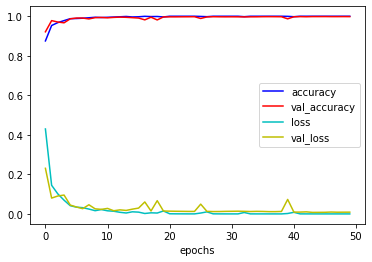

In [15]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l2 = layers.Conv1D(channels, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l4 = layers.Conv1D(channels, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l6 = layers.Conv1D(channels * 2, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l8 = layers.Conv1D(channels * 2, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels * 4, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l12 = layers.Conv1D(channels * 4, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l14 = layers.Conv1D(channels * 8, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l16 = layers.Conv1D(channels * 8, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

In [16]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

8886.0
prediction arrhythmia as normal:  17
prediction normal as arrhythmia:  7


### 2.5. filter size = 7 ResNet

Epoch 1/50
627/627 [==============================] - 24s 37ms/step - loss: 0.4415 - accuracy: 0.8756 - val_loss: 0.1880 - val_accuracy: 0.9392
Epoch 2/50
627/627 [==============================] - 23s 37ms/step - loss: 0.1317 - accuracy: 0.9587 - val_loss: 0.0885 - val_accuracy: 0.9747
Epoch 3/50
627/627 [==============================] - 23s 37ms/step - loss: 0.1047 - accuracy: 0.9671 - val_loss: 0.0549 - val_accuracy: 0.9802
Epoch 4/50
627/627 [==============================] - 23s 36ms/step - loss: 0.0532 - accuracy: 0.9830 - val_loss: 0.0334 - val_accuracy: 0.9880
Epoch 5/50
627/627 [==============================] - 23s 37ms/step - loss: 0.0376 - accuracy: 0.9879 - val_loss: 0.0380 - val_accuracy: 0.9879
Epoch 6/50
627/627 [==============================] - 23s 37ms/step - loss: 0.0250 - accuracy: 0.9927 - val_loss: 0.0280 - val_accuracy: 0.9919
Epoch 7/50
627/627 [==============================] - 23s 36ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.1084 - val_accuracy:

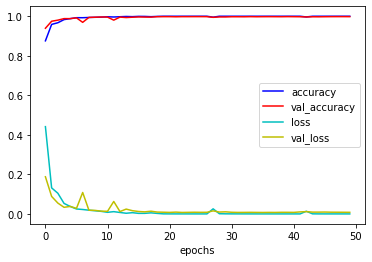

In [17]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l2 = layers.Conv1D(channels, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l4 = layers.Conv1D(channels, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l6 = layers.Conv1D(channels * 2, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l8 = layers.Conv1D(channels * 2, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels * 4, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l12 = layers.Conv1D(channels * 4, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l14 = layers.Conv1D(channels * 8, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l16 = layers.Conv1D(channels * 8, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

In [18]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

8887.0
prediction arrhythmia as normal:  13
prediction normal as arrhythmia:  10


### 2.6. filter size = 10 ResNet

Epoch 1/50
627/627 [==============================] - 29s 44ms/step - loss: 0.3305 - accuracy: 0.8857 - val_loss: 0.2471 - val_accuracy: 0.8997
Epoch 2/50
627/627 [==============================] - 27s 43ms/step - loss: 0.1117 - accuracy: 0.9618 - val_loss: 0.0602 - val_accuracy: 0.9834
Epoch 3/50
627/627 [==============================] - 27s 43ms/step - loss: 0.0533 - accuracy: 0.9842 - val_loss: 0.0367 - val_accuracy: 0.9894
Epoch 4/50
627/627 [==============================] - 27s 43ms/step - loss: 0.0406 - accuracy: 0.9863 - val_loss: 0.0310 - val_accuracy: 0.9913
Epoch 5/50
627/627 [==============================] - 27s 43ms/step - loss: 0.0293 - accuracy: 0.9902 - val_loss: 0.0265 - val_accuracy: 0.9921
Epoch 6/50
627/627 [==============================] - 27s 43ms/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0266 - val_accuracy: 0.9924
Epoch 7/50
627/627 [==============================] - 27s 43ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0152 - val_accuracy:

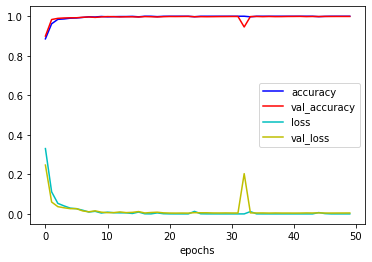

In [19]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l2 = layers.Conv1D(channels, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l4 = layers.Conv1D(channels, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l6 = layers.Conv1D(channels * 2, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l8 = layers.Conv1D(channels * 2, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l10 = layers.Conv1D(channels * 4, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l12 = layers.Conv1D(channels * 4, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l14 = layers.Conv1D(channels * 8, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l16 = layers.Conv1D(channels * 8, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

In [20]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

8898.0
prediction arrhythmia as normal:  8
prediction normal as arrhythmia:  4


### 2.7. filter size = 5(BN)

Epoch 1/50
627/627 [==============================] - 42s 46ms/step - loss: 0.3031 - accuracy: 0.8992 - val_loss: 0.1295 - val_accuracy: 0.9636
Epoch 2/50
627/627 [==============================] - 28s 45ms/step - loss: 0.0862 - accuracy: 0.9713 - val_loss: 0.0517 - val_accuracy: 0.9841
Epoch 3/50
627/627 [==============================] - 28s 45ms/step - loss: 0.0389 - accuracy: 0.9882 - val_loss: 0.0902 - val_accuracy: 0.9752
Epoch 4/50
627/627 [==============================] - 28s 44ms/step - loss: 0.0286 - accuracy: 0.9913 - val_loss: 0.0209 - val_accuracy: 0.9921
Epoch 5/50
627/627 [==============================] - 28s 44ms/step - loss: 0.0201 - accuracy: 0.9926 - val_loss: 0.0244 - val_accuracy: 0.9913
Epoch 6/50
627/627 [==============================] - 28s 44ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0316 - val_accuracy: 0.9903
Epoch 7/50
627/627 [==============================] - 28s 44ms/step - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.0121 - val_accuracy:

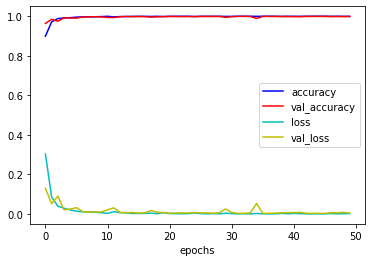

In [19]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l1 = layers.BatchNormalization()(l1)
l2 = layers.Conv1D(channels, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l3 = layers.BatchNormalization()(l3)
l4 = layers.Conv1D(channels, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l5 = layers.BatchNormalization()(l5)
l6 = layers.Conv1D(channels * 2, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l7 = layers.BatchNormalization()(l7)
l8 = layers.Conv1D(channels * 2, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l9 = layers.BatchNormalization()(l9)
l10 = layers.Conv1D(channels * 4, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l11 = layers.BatchNormalization()(l11)
l12 = layers.Conv1D(channels * 4, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l13 = layers.BatchNormalization()(l13)
l14 = layers.Conv1D(channels * 8, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 5, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l14 = layers.BatchNormalization()(l14)
l16 = layers.Conv1D(channels * 8, 5, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))
    
print(ResNet18_ecg.summary())    

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

In [20]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

279/279 [==============================] - 3s 11ms/step
8897.0
prediction arrhythmia as normal:  8
prediction normal as arrhythmia:  5


### 2.8. filter size = 7(BN)

Epoch 1/50
627/627 [==============================] - 37s 55ms/step - loss: 0.2603 - accuracy: 0.9125 - val_loss: 0.0629 - val_accuracy: 0.9801
Epoch 2/50
627/627 [==============================] - 33s 52ms/step - loss: 0.0524 - accuracy: 0.9833 - val_loss: 0.0551 - val_accuracy: 0.9785
Epoch 3/50
627/627 [==============================] - 33s 52ms/step - loss: 0.0238 - accuracy: 0.9917 - val_loss: 0.0126 - val_accuracy: 0.9958
Epoch 4/50
627/627 [==============================] - 33s 52ms/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0085 - val_accuracy: 0.9976
Epoch 5/50
627/627 [==============================] - 33s 53ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.0064 - val_accuracy: 0.9979
Epoch 6/50
627/627 [==============================] - 33s 52ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0259 - val_accuracy: 0.9981
Epoch 7/50
627/627 [==============================] - 33s 52ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy:

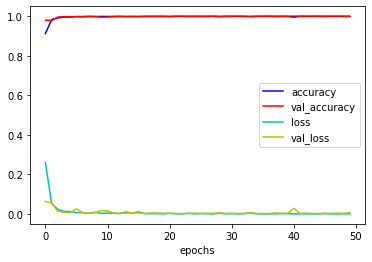

In [21]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l1 = layers.BatchNormalization()(l1)
l2 = layers.Conv1D(channels, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l3 = layers.BatchNormalization()(l3)
l4 = layers.Conv1D(channels, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2

l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l5 = layers.BatchNormalization()(l5)
l6 = layers.Conv1D(channels * 2, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l7 = layers.BatchNormalization()(l7)
l8 = layers.Conv1D(channels * 2, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l9 = layers.BatchNormalization()(l9)
l10 = layers.Conv1D(channels * 4, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l11 = layers.BatchNormalization()(l11)
l12 = layers.Conv1D(channels * 4, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l13 = layers.BatchNormalization()(l13)
l14 = layers.Conv1D(channels * 8, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 7, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l14 = layers.BatchNormalization()(l14)
l16 = layers.Conv1D(channels * 8, 7, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))
    
print(ResNet18_ecg.summary())    

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

In [23]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

279/279 [==============================] - 4s 13ms/step
8901.0
prediction arrhythmia as normal:  0
prediction normal as arrhythmia:  9


### 2.9. filter size = 10(BN)

Epoch 1/50
627/627 [==============================] - 38s 57ms/step - loss: 0.2568 - accuracy: 0.9109 - val_loss: 0.1781 - val_accuracy: 0.9397
Epoch 2/50
627/627 [==============================] - 35s 57ms/step - loss: 0.0474 - accuracy: 0.9849 - val_loss: 0.0165 - val_accuracy: 0.9936
Epoch 3/50
627/627 [==============================] - 36s 57ms/step - loss: 0.0232 - accuracy: 0.9923 - val_loss: 0.0157 - val_accuracy: 0.9939
Epoch 4/50
627/627 [==============================] - 36s 57ms/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.0110 - val_accuracy: 0.9955
Epoch 5/50
627/627 [==============================] - 36s 57ms/step - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.0086 - val_accuracy: 0.9961
Epoch 6/50
627/627 [==============================] - 36s 57ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 7/50
627/627 [==============================] - 36s 57ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.0191 - val_accuracy:

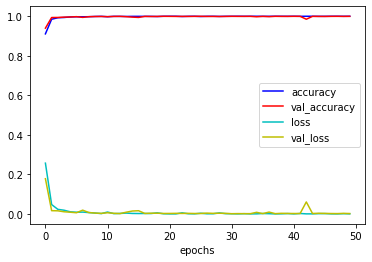

In [25]:
input_tensor = Input(shape=(1280, 1), dtype='float16', name='input')
channels = 32

#Conv0
l0 = layers.Conv1D(channels, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)

#Conv1
l1 = layers.Conv1D(channels, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l0)
l1 = layers.BatchNormalization()(l1)
l2 = layers.Conv1D(channels, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l1)
i1 = layers.add([l2, l0])
l2 = layers.Activation('relu')(i1)
l3 = layers.Conv1D(channels, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l2)
l3 = layers.BatchNormalization()(l3)
l4 = layers.Conv1D(channels, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l3)
i2 = layers.add([l4, l2])
l4 = layers.Activation('relu')(i2)

#Conv2
l4 = layers.MaxPooling1D(pool_size=2, padding='same')(l4)
l5 = layers.Conv1D(channels * 2, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l4)
l5 = layers.BatchNormalization()(l5)
l6 = layers.Conv1D(channels * 2, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l5)
l4 = layers.Conv1D(channels * 2, 1, padding='same', strides = 1)(l4)
i3 = layers.add([l6, l4])
l6 = layers.Activation('relu')(i3)
l7 = layers.Conv1D(channels * 2, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l6)
l7 = layers.BatchNormalization()(l7)
l8 = layers.Conv1D(channels * 2, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l7)
i4 = layers.add([l8, l6])
l8 = layers.Activation('relu')(i4)

#Conv3
l8 = layers.MaxPooling1D(pool_size=2, padding='same')(l8)
l9 = layers.Conv1D(channels * 4, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l8)
l9 = layers.BatchNormalization()(l9)
l10 = layers.Conv1D(channels * 4, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l9)
l8 = layers.Conv1D(channels * 4, 1,  padding='same', strides = 1)(l8)
i5 = layers.add([l10, l8])
l10 = layers.Activation('relu')(i5)
l11 = layers.Conv1D(channels * 4, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l10)
l11 = layers.BatchNormalization()(l11)
l12 = layers.Conv1D(channels * 4, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l11)
i6 = layers.add([l12, l10])
l12 = layers.Activation('relu')(i6)


#Conv4
l12 = layers.MaxPooling1D(pool_size=2, padding='same')(l12)
l13 = layers.Conv1D(channels * 8, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l12)
l13 = layers.BatchNormalization()(l13)
l14 = layers.Conv1D(channels * 8, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l13)
l12 = layers.Conv1D(channels * 8, 1, padding='same', strides = 1)(l12)
i7 = layers.add([l14, l12])
l14 = layers.Activation('relu')(i7)
l15 = layers.Conv1D(channels * 8, 10, strides = 1, activation='relu', padding='same', kernel_initializer='he_normal')(l14)
l14 = layers.BatchNormalization()(l14)
l16 = layers.Conv1D(channels * 8, 10, strides = 1, padding='same', kernel_initializer='he_normal')(l15)
l16 = layers.add([l16, l14])
l16 = layers.Activation('relu')(l16)

#avg pool
avg = layers.AveragePooling1D(2, strides = 2)(l16)
avg = layers.Flatten()(avg)

#FC
fc = layers.Dense(1000, kernel_initializer ='he_normal')(avg)

#Output Layer
output_tensor = layers.Dense(2, activation ='softmax')(fc)

#ResNet-18 Model
ResNet18_ecg = Model(input_tensor, output_tensor)

ResNet18_ecg.compile(loss='binary_crossentropy', optimizer = tf.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])

with tf.device('/device:GPU:0'): 
    history = ResNet18_ecg.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))
    
print(ResNet18_ecg.summary())    

test_loss, test_acc = ResNet18_ecg.evaluate(x_test, y_test)
print('***result***')
print('test accuracy: ', test_acc, 'test loss: ', test_loss)
        
plt.figure(1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.plot(history.history['loss'], 'c')
plt.plot(history.history['val_loss'], 'y')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

plt.show()

In [26]:
y_predict = ResNet18_ecg.predict(x_test)

y_predict = np.round(y_predict, 0)

result = y_predict * y_test

print(np.sum(result))

arrhy2nor = []
nor2arrhy = []

#count of preciction arrhythmia as normal
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [-1., 1.]).all() == True:
            arrhy2nor.append(i)

#count of preciction normal as arrhythmia            
for i in range(len(y_predict)):
    if ((y_predict[i] - y_test[i]) == [1., -1.]).all() == True:
            nor2arrhy.append(i)
                                             
            
print('prediction arrhythmia as normal: ', len(arrhy2nor))
print('prediction normal as arrhythmia: ', len(nor2arrhy))   

8906.0
prediction arrhythmia as normal:  1
prediction normal as arrhythmia:  3


In [31]:
ResNet18_ecg.save('filter_size_10_BN')

INFO:tensorflow:Assets written to: filter_size_10_BN\assets


C:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\user\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
